# Drug Consumption: Testes com Classificadores

In [73]:
import pandas as pd
import numpy as np
import utils as ut
from pprint import pprint

from os.path import exists

from importlib import reload

reload(ut)

<module 'utils' from '/home/ngmonteiro/llm_experiments/ufes/2024-1-P1-Drug-Consumption/utils.py'>

In [74]:
data = pd.read_csv("data/drug_consumption_preprocessed.csv", index_col="ID")
pd.set_option("display.max_columns", None)

# Coloque "True" se quiser rodar os experimentos ao invés de carregar resultados anteriores.
run = False

ut.create_dirs()

# Análises

## Características Normalizadas
São criados métodos que serão utilizados posteriormente para auxiliar na organização. Código encontrado em "utils.py"

```python
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

numCols = [
    "Neuroticism",
    "Extraversion",
    "Openness",
    "Agreeableness",
    "Conscientiousness",
    "Impulsiveness",
    "Sensationness",
]


def metric_preprocessor():
    return ColumnTransformer(
        [("numerical", StandardScaler(), numCols)],
        verbose_feature_names_out=False,
        remainder="passthrough",
    )
```

## Análise de Substâncias
No dataset são descritas 18 tipos de substâncias lícitas e ilícitas, além de uma substância que é fictícia. Tal inserção é justificada pelo fato que o dataset leva em consideração que alguns dos indivíduos podem ser "over-claimers", ou seja, podem não ser fontes de informação tão confiáveis.

Dessa forma, temos duas opções:
- Remover os dados que podem ser exagerados ou
- Deixar os dados, já que são mínimos e podem não afetar o modelo.

Aqui, optamos por usar o dataset sem os ruídos.

In [75]:
print(data["Semer"].value_counts())

# Versão sem os indivíduos menos confiáveis.
data_filtered = data[data["Semer"] == 0]

0    1877
2       3
3       2
1       2
4       1
Name: Semer, dtype: int64


## Análise de Características
Podemos tentar analisar o quão essenciais algumas características podem ser em relação à variação dos dados. Dessa forma, podemos selecionar um subconjunto que possa classificar e generalizar melhor os modelos.

In [76]:
# Ignorando o país de residência + nominais + droga fictícia.
ignore_cols = (
    ["Country", "Age_", "Education_", "Semer", "Semer_", "Ethnicity"]
    + [x + "_" for x in ut.drugs]
    + ut.drugs
)

X = data_filtered.drop(columns=ignore_cols)

In [77]:
from sklearn.feature_selection import SelectKBest

feature_df = pd.DataFrame(index=ut.drugs, columns=X.columns)
for d in ut.drugs:
    selector = SelectKBest(k="all").fit(X, data_filtered[d])
    for x, y in zip(selector.scores_, selector.feature_names_in_):
        feature_df.loc[d, y] = x

feature_df.mean().sort_values(ascending=False)

Age                 42.73
Sensationness       34.11
Openness            21.04
Impulsiveness       17.25
Education           16.44
Gender              14.77
Conscientiousness   12.72
Agreeableness        6.21
Neuroticism          6.14
Extraversion         3.14
dtype: float64

# Teste com LazyPredict
Aqui realizamos o teste de classificadores com LazyClassifier para todas as substâncias. Dessa forma, podemos observar os classificadores que mais frequentemente retornam os maiores valores.

Para facilitar o trabalho dos classificadores, estamos considerando o problema como binário:
- 1 para indivíduos que tiveram contato com a substância pelo menos que t.
- 0 para indivíduos que não tiveram contato em um tempo maior que t.

em que t pode ser tanto década, ano, mês, semana ou dia.

Com isso, podemos analisar casos mais recorrentes ao invés de focar em casos excepcionais como casos isolados em tempos muito curtos, o que podem prejudicar a classificação de usuários com uso mais constante.

In [78]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import StratifiedKFold


def run_classifiers(t=2):
    all_results = {}

    for d in ut.drugs:
        # Não precisamos de contabilizar a classificação de drogas mais gerais/fictícias.
        if d in ut.lesser_drugs:
            continue

        all_results[d] = []

        # Labels são transformados em binário com um threshold.
        labels = np.where(data_filtered[d] > t, 1, 0)

        n_splits = 4
        cv = StratifiedKFold(n_splits=n_splits)
        classif_avg = {}

        for train, test in cv.split(X, labels):
            # Normalizando as características de métricas de personalidade
            preprocessor = ut.metric_preprocessor()
            train_scaled = preprocessor.fit_transform(X.iloc[train])
            test_scaled = preprocessor.transform(X.iloc[test])

            clf = LazyClassifier()
            models, _ = clf.fit(train_scaled, test_scaled, labels[train], labels[test])

            for c, s in models.iterrows():
                classif_avg[c] = (
                    classif_avg.get(c, 0) + s["Balanced Accuracy"] / n_splits
                )

        all_results[d] = classif_avg

    return all_results

In [79]:
t = 2
path = "results/classifier_scores.csv"

if run or not exists(path):
    results = run_classifiers(t=t)

    classifiers = {}
    for k, i in results.items():
        for c, s in i.items():
            classifiers[c] = classifiers.get(c, 0) + s

    all_models_sorted = sorted(classifiers.items(), key=lambda item: -item[1])

    # Guarda as pontuações para uso posterior, se necessário
    classifier_df = pd.DataFrame.from_records(
        all_models_sorted, columns=["Classifier", "Score"]
    )
    classifier_df.to_csv(path)
else:
    classifier_df = pd.read_csv(path, index_col="Classifier")

In [80]:
k = 3
print(f"\nOs {k} classificadores com maior pontuação acumulada para t={t} são:")
pprint(classifier_df.iloc[:k])


Os 3 classificadores com maior pontuação acumulada para t=2 são:
                 Unnamed: 0  Score
Classifier                        
NearestCentroid           0  10.82
GaussianNB                1   9.98
BernoulliNB               2   9.61


## Teste c/ Cross-Validation
Foi realizado um teste com 8 folds estratificados em cross-validation, sem hiperparametrização, com alguns dos classificadores acima.

In [81]:
t = 2


def all_run():
    labels = data_filtered[ut.drugs].applymap(ut.threshold, t=[t])
    return ut.test_classifiers(X, labels)


results, cm = ut.run_or_load("results/common_{a}.csv", all_run if run else None)

Substância             Alcohol      Amphet      Amyl      Benzos      Caff  \
                          mean  std   mean  std mean  std   mean  std mean   
Model                                                                        
BernoulliNB               0.50 0.00   0.67 0.03 0.52 0.02   0.65 0.04 0.50   
GaussianNB                0.51 0.02   0.70 0.03 0.55 0.04   0.66 0.04 0.50   
KNeighborsClassifier      0.50 0.00   0.68 0.03 0.52 0.02   0.64 0.04 0.50   
NearestCentroid           0.63 0.08   0.71 0.03 0.62 0.05   0.67 0.04 0.67   
RandomForestClassifier    0.50 0.00   0.68 0.03 0.50 0.01   0.65 0.03 0.50   

Substância                  Cannabis      Choc      Coke      Crack       \
                        std     mean  std mean  std mean  std  mean  std   
Model                                                                      
BernoulliNB            0.00     0.74 0.03 0.50 0.00 0.64 0.03  0.58 0.04   
GaussianNB             0.00     0.77 0.04 0.50 0.00 0.67 0.03  0.59 0.06   
KNeighborsClassifier   0.00     0.75 0.03 0.50 0.00 0.65 0.04  0.50 0.01   
NearestCentroid        0.15     0.77 0.03 0.50 0.14 0.68 0.03  0.66 0.05   
RandomForestClassifier 0.00     0.75 0.02 0.50 0.00 0.65 0.02  0.50 0.01   

Substância             Ecstasy      Heroin      Ketamine       LSD       \
                          mean  std   mean  std     mean  std mean  std   
Model                                                                     
BernoulliNB               0.71 0.03   0.60 0.05     0.59 0.04 0.71 0.05   
GaussianNB                0.74 0.03   0.63 0.05     0.62 0.04 0.74 0.03   
KNeighborsClassifier      0.72 0.04   0.51 0.01     0.53 0.03 0.69 0.04   
NearestCentroid           0.74 0.03   0.70 0.06     0.67 0.05 0.75 0.03   
RandomForestClassifier    0.73 0.03   0.51 0.02     0.51 0.02 0.71 0.04   

Substância             Legalh      Meth      Mushrooms      Nicotine       \
                         mean  std mean  std      mean  std     mean  std   
Model                                                                       
BernoulliNB              0.76 0.03 0.63 0.04      0.69 0.03     0.66 0.04   
GaussianNB               0.78 0.03 0.66 0.04      0.73 0.04     0.69 0.03   
KNeighborsClassifier     0.77 0.03 0.58 0.03      0.71 0.03     0.64 0.03   
NearestCentroid          0.78 0.03 0.70 0.03      0.74 0.03     0.69 0.04   
RandomForestClassifier   0.77 0.03 0.57 0.03      0.70 0.03     0.63 0.04   

Substância              VSA       
                       mean  std  
Model                             
BernoulliNB            0.64 0.05  
GaussianNB             0.67 0.05  
KNeighborsClassifier   0.52 0.02  
NearestCentroid        0.75 0.04  
RandomForestClassifier 0.51 0.02

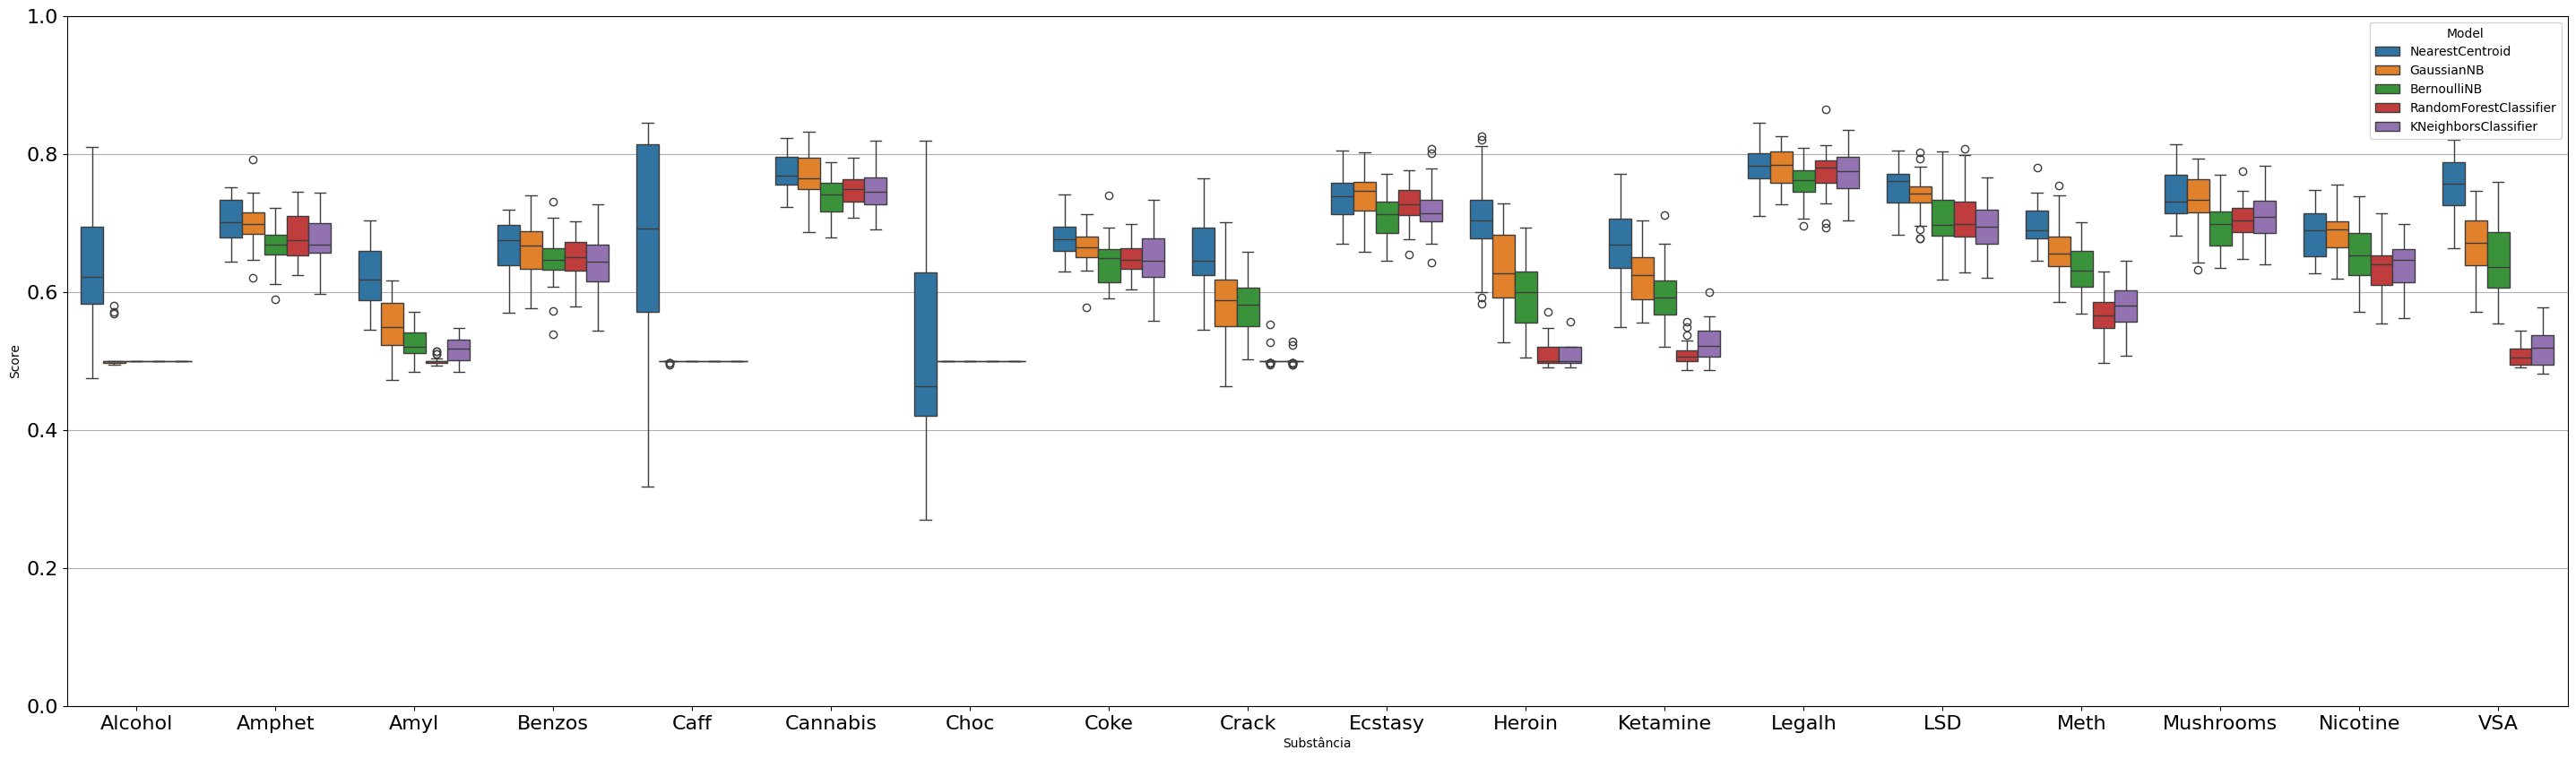

In [82]:
fig = ut.boxplot(results, f"Resultados com o threshold t={t}")
fig.savefig("figures/common.svg", bbox_inches='tight')
ut.show_statistics(results)

Substância Alcohol      Amphet      Amyl      Benzos      Caff      Cannabis  \
              mean  std   mean  std mean  std   mean  std mean  std     mean   
Model                                                                          
Modelo        0.53 0.06   0.69 0.04 0.54 0.05   0.65 0.04 0.53 0.09     0.75   

Substância      Choc      Coke      Crack      Ecstasy      Heroin       \
            std mean  std mean  std  mean  std    mean  std   mean  std   
Model                                                                     
Modelo     0.03 0.50 0.06 0.66 0.04  0.56 0.07    0.73 0.03   0.59 0.09   

Substância Ketamine       LSD      Legalh      Meth      Mushrooms       \
               mean  std mean  std   mean  std mean  std      mean  std   
Model                                                                     
Modelo         0.58 0.07 0.72 0.04   0.77 0.03 0.63 0.06      0.72 0.04   

Substância Nicotine       VSA       
               mean  std mean  std  
Model                               
Modelo         0.66 0.04 0.62 0.10

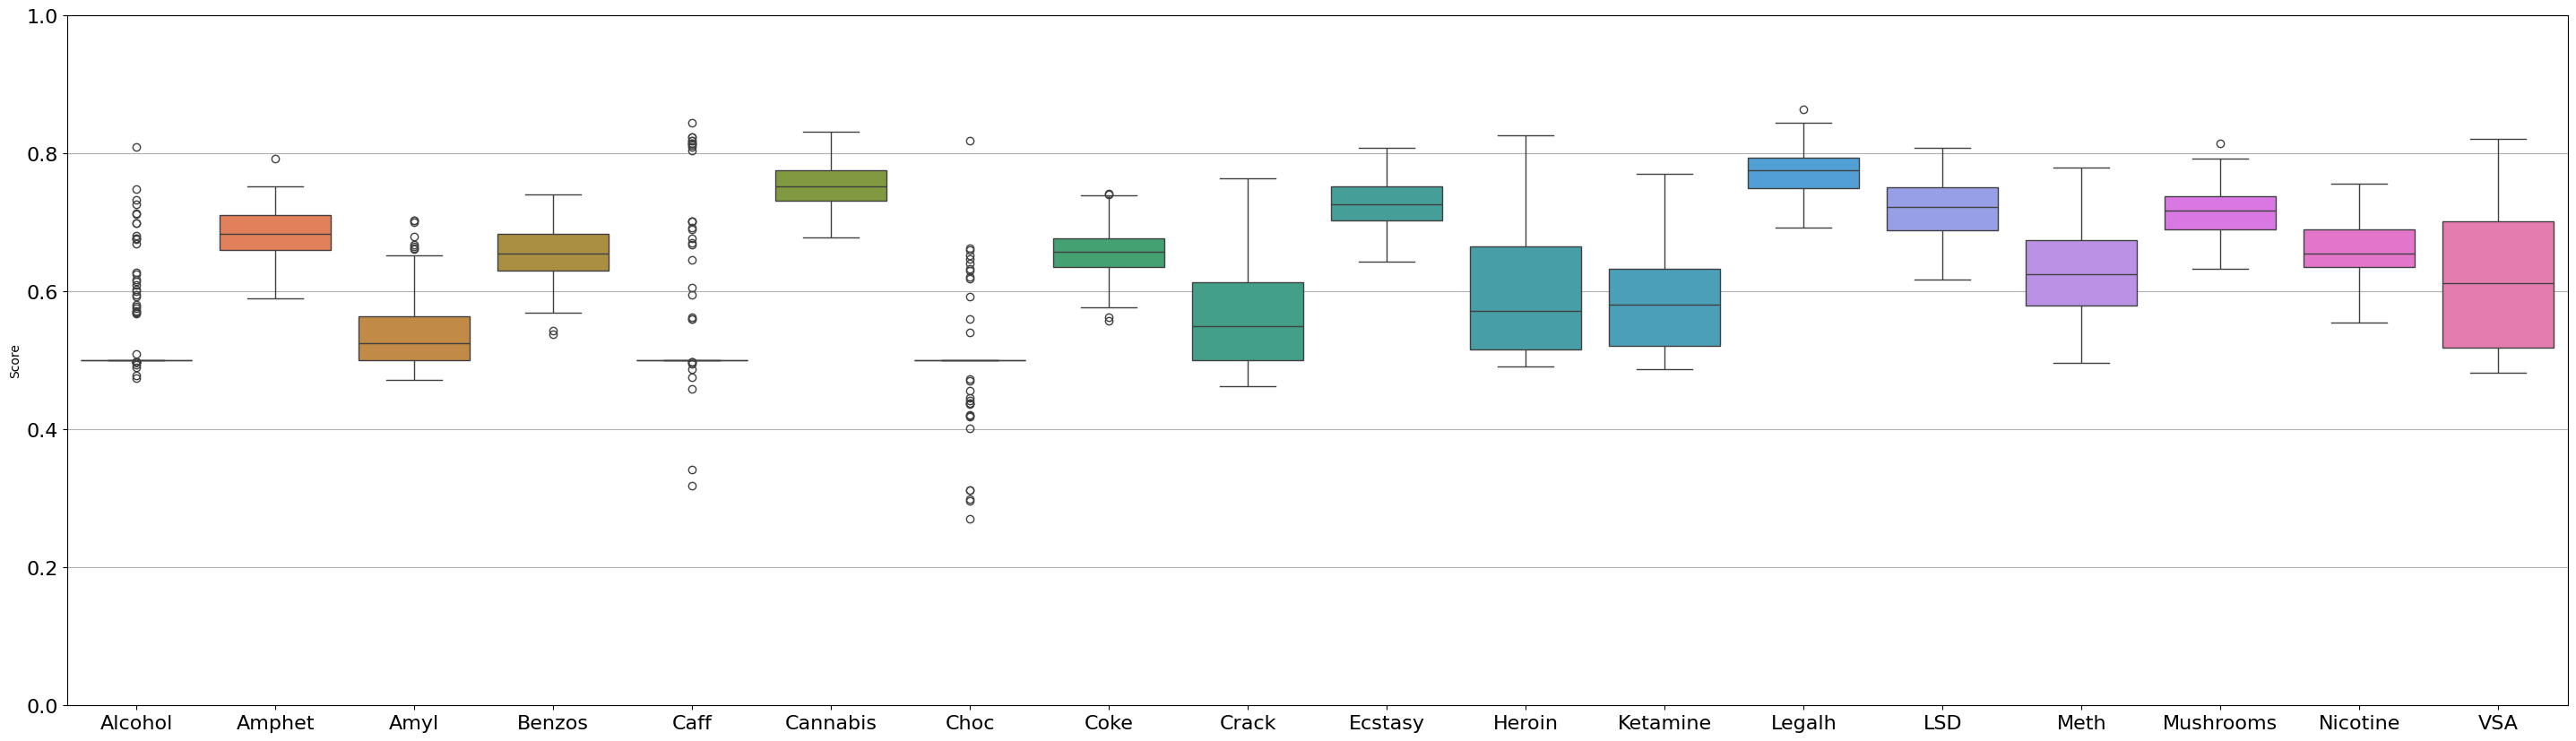

In [83]:
results_m = results.copy()
results_m["Model"] = "Modelo"

fig = ut.boxplot(results_m, f"Resultados do modelo geral com o threshold t={t}")
fig.savefig("figures/common_m.svg", bbox_inches='tight')
ut.show_statistics(results_m)

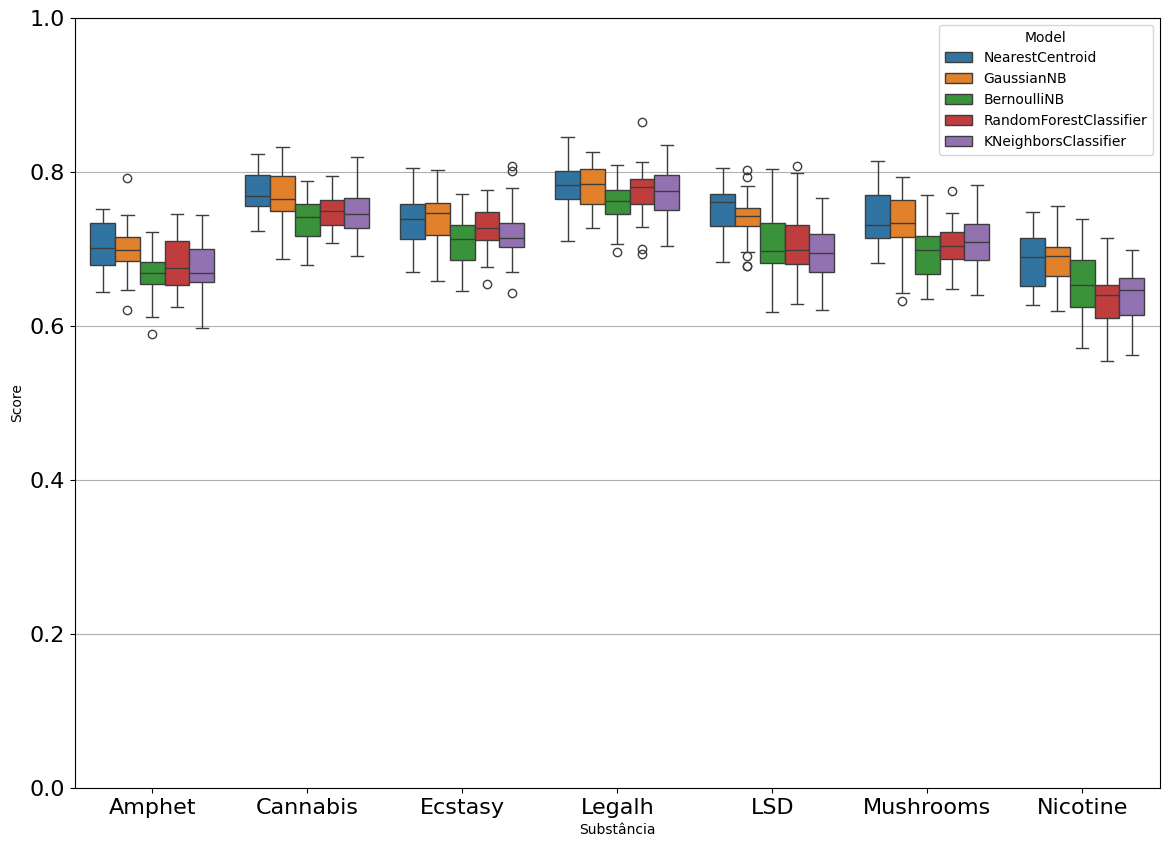

In [84]:
filter = ut.get_k_highest_mean(results, k=7)

fig = ut.boxplot(
    results,
    title=f"Resultados com o threshold t={t}",
    substance_filter=filter,
)
fig.savefig("figures/common_k.svg", bbox_inches='tight')

### Confusion Matrices

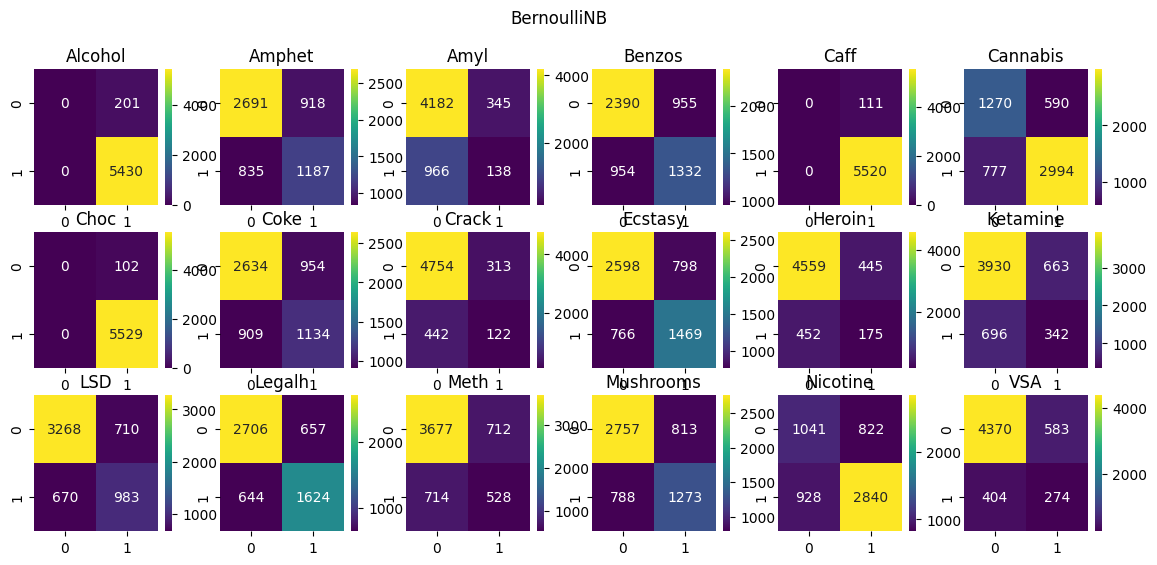

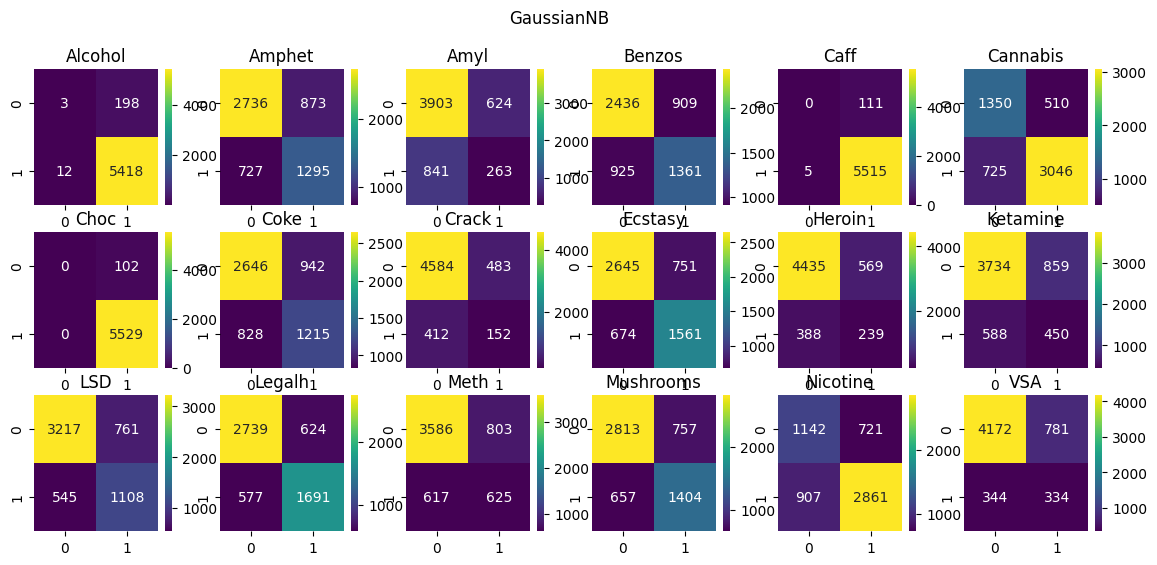

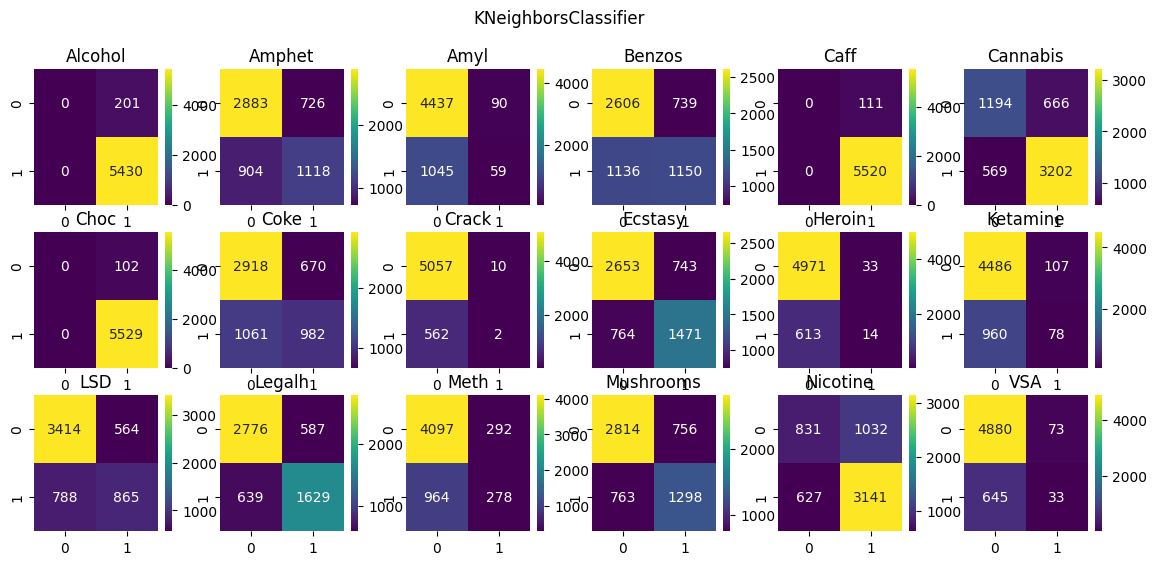

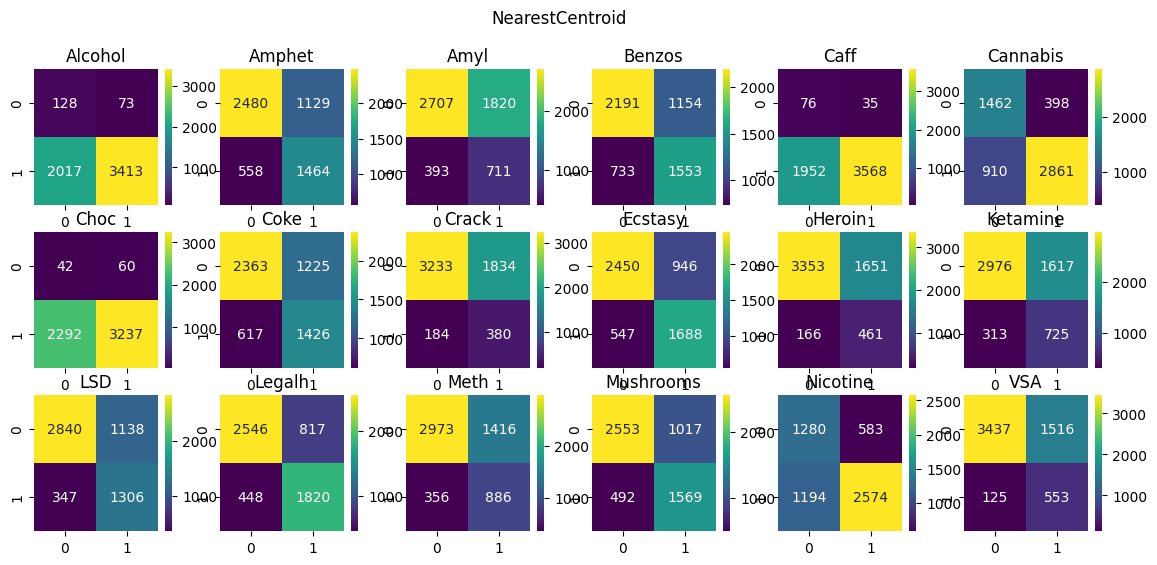

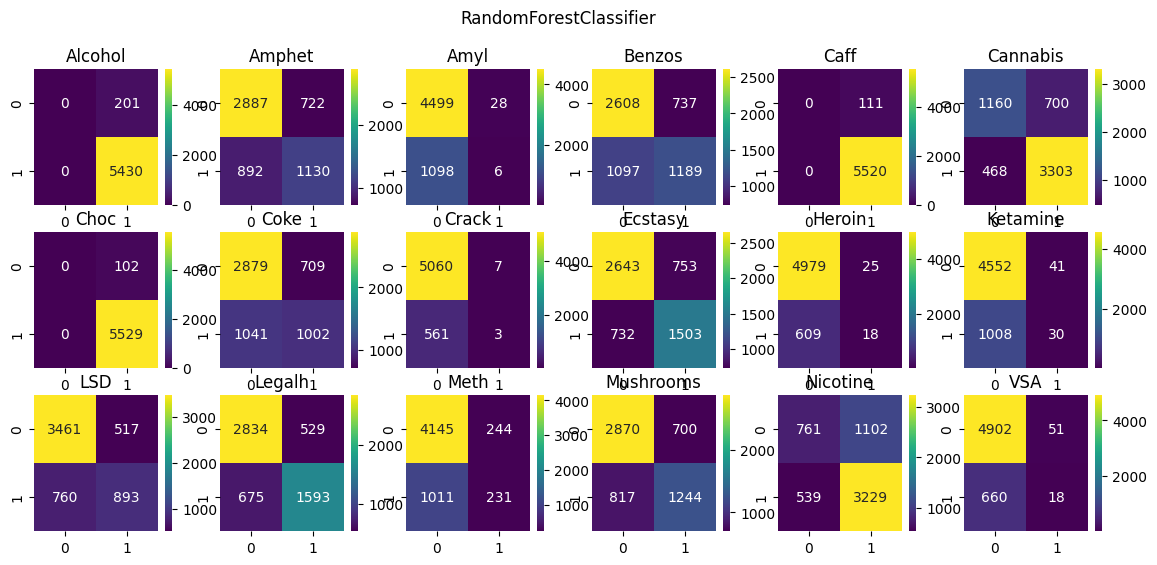

In [85]:
ut.confusion(cm)